In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 3a
commitnumber = f17e0b2
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [-2, 0]
ng_refs = [2, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(10, 250), (600, 250)]
tsfc = 300
w_diffuse = [(1.9, 1.7), (1.4, 1.4, 1.4, 1.55, 1.6, 1.66)]
wgt = [(0.7, 0.7), (0.7, 0.5, 0.5, 0.5, 0.5, 0.5)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

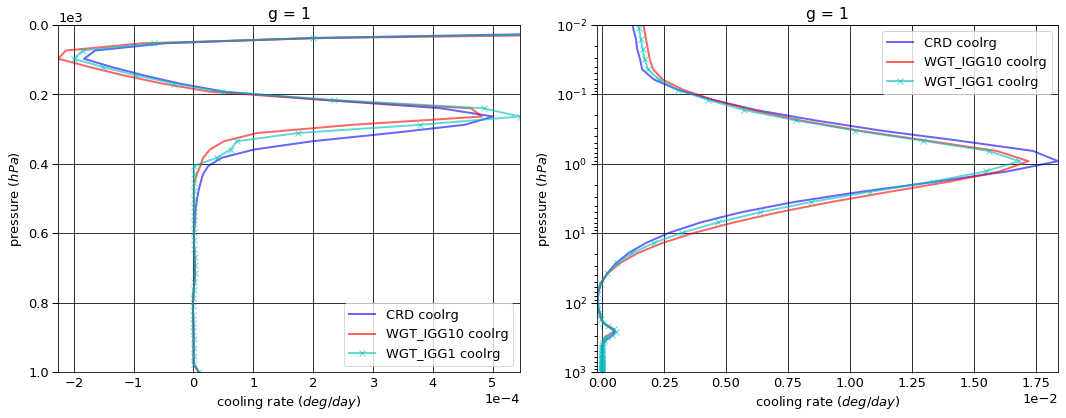

# Figure: cooling rate g-group 2

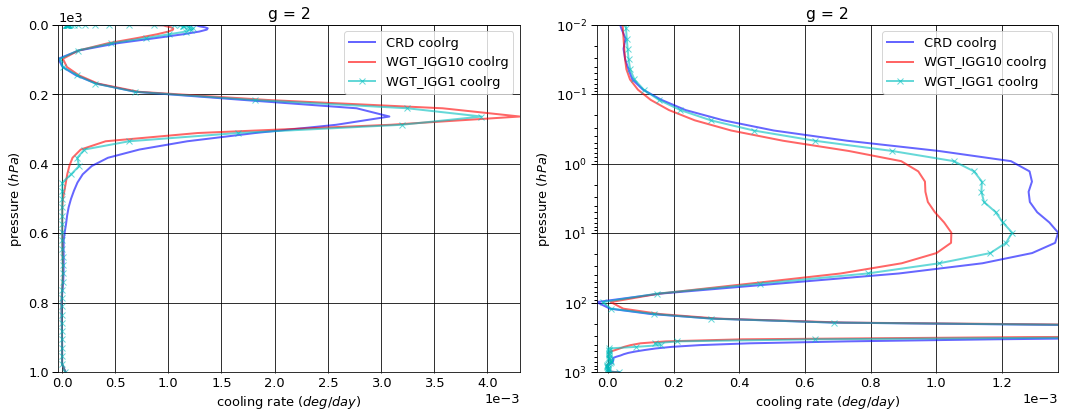

# Figure: cooling rate g-group 3

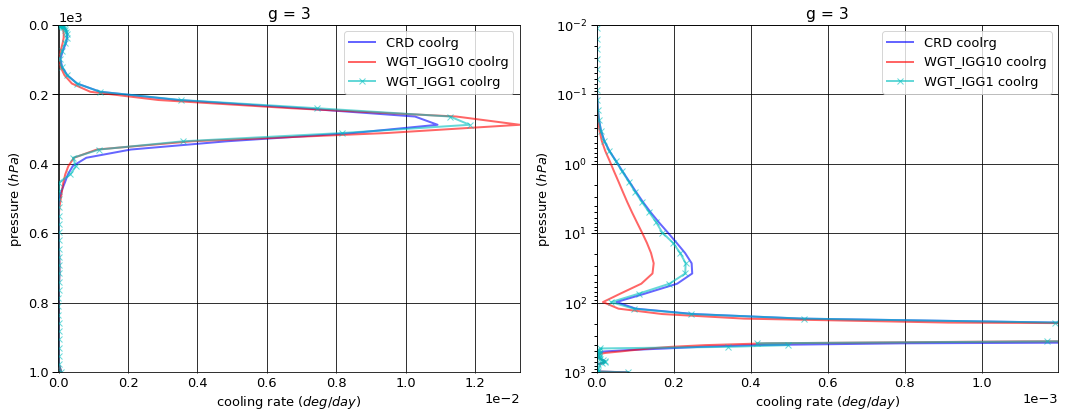

# Figure: cooling rate g-group 4

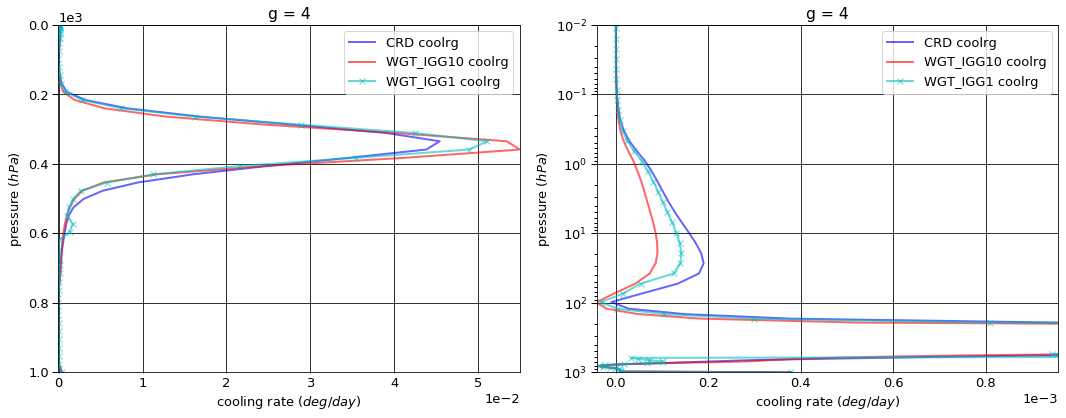

# Figure: cooling rate g-group 5

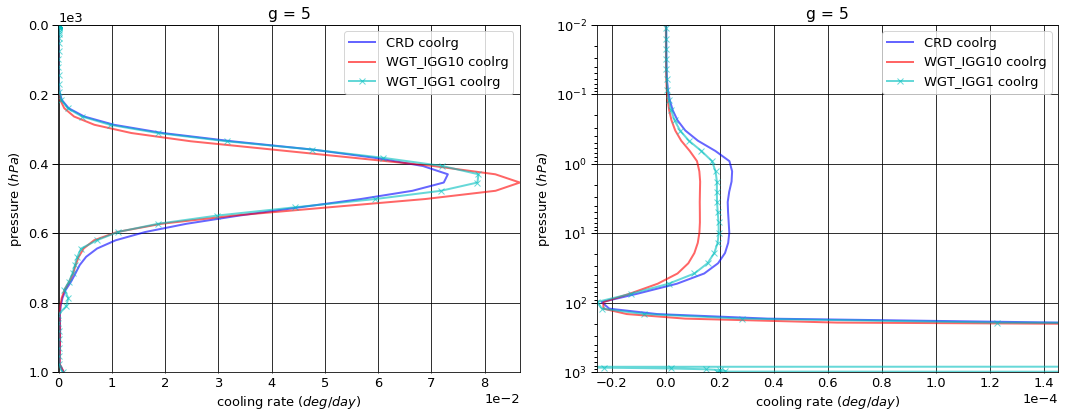

# Figure: cooling rate g-group 6

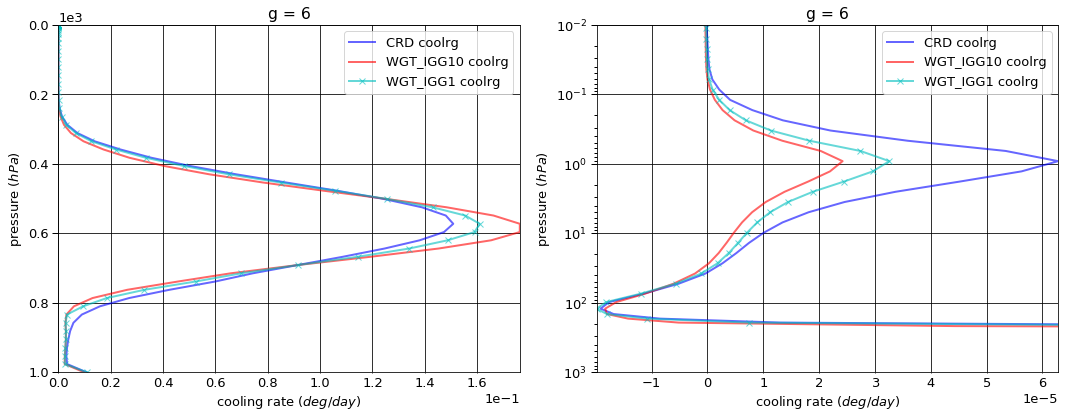

# Figure: cooling rate g-group 7

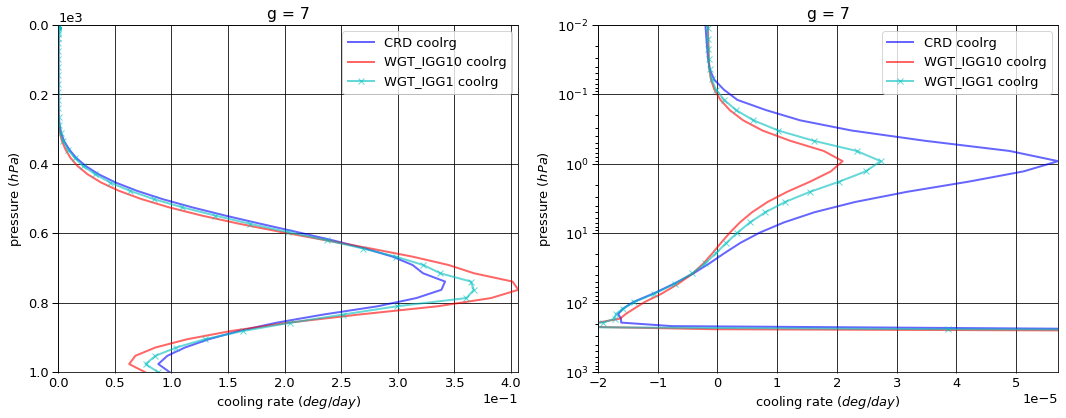

# Figure: cooling rate g-group 8

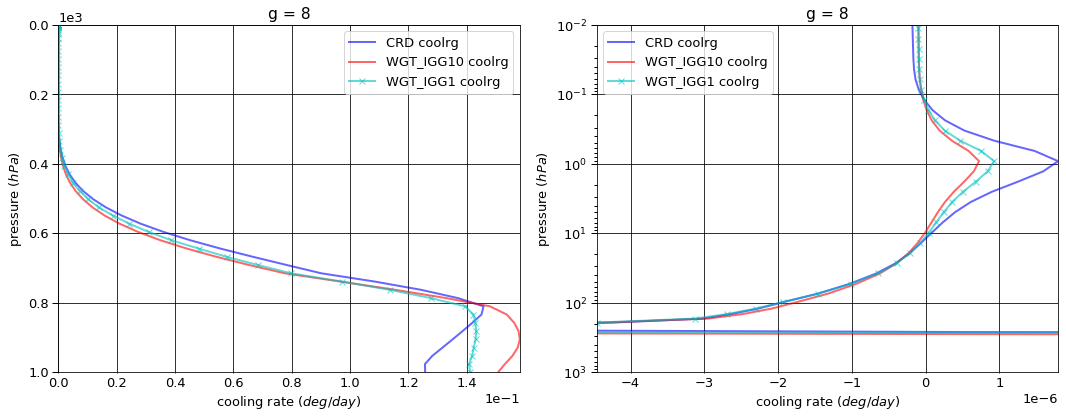

# Figure: cooling rate g-group total

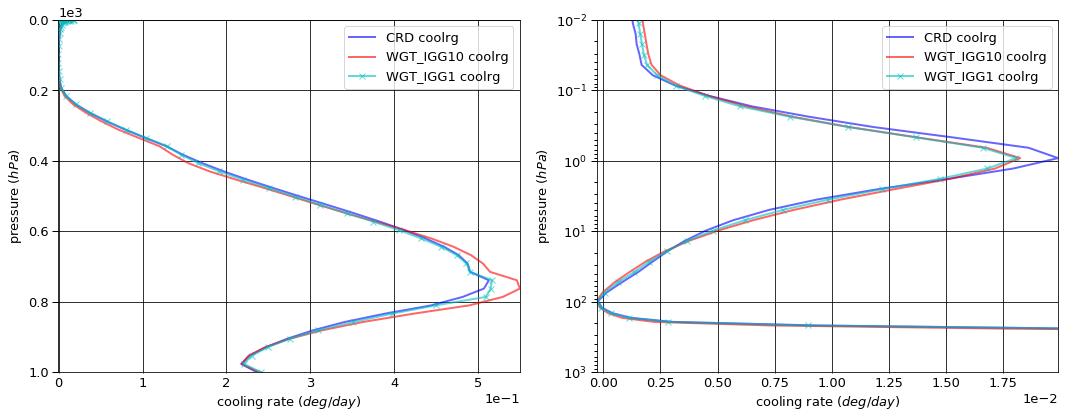

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.016636   0.000000  -0.016636
  1013.0   76     -0.037525   0.037500  -0.000025
2 0.0      1      -0.054212   0.000000  -0.054212
  1013.0   76     -0.136128   0.136032  -0.000096
3 0.0      1      -0.146127   0.000000  -0.146127
  1013.0   76     -0.338228   0.338002  -0.000226
4 0.0      1      -0.807492   0.000000  -0.807492
  1013.0   76     -1.582274   1.581217  -0.001057
5 0.0      1      -1.892932   0.000000  -1.892932
  1013.0   76     -3.122535   3.120068  -0.002466
6 0.0      1      -5.193661   0.000000  -5.193661
  1013.0   76     -7.304821   7.274154  -0.030667
7 0.0      1     -14.099705   0.000000 -14.099705
  1013.0   76    -17.298325  16.717393  -0.580932
8 0.0      1      -7.779513   0.000000  -7.779513
  1013.0   76     -8.671899   6.696660  -1.975238


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.016157   0.000000  -0.016157
  1013.0   76     -0.037525   0.037500  -0.000025
2 0.0      1      -0.052316   0.000000  -0.052316
  1013.0   76     -0.136128   0.136037  -0.000091
3 0.0      1      -0.146966   0.000000  -0.146966
  1013.0   76     -0.338228   0.338002  -0.000226
4 0.0      1      -0.811729   0.000000  -0.811729
  1013.0   76     -1.582274   1.581217  -0.001057
5 0.0      1      -1.908503   0.000000  -1.908503
  1013.0   76     -3.122535   3.119994  -0.002540
6 0.0      1      -5.207649   0.000000  -5.207649
  1013.0   76     -7.304821   7.278989  -0.025832
7 0.0      1     -14.147128   0.000000 -14.147128
  1013.0   76    -17.298325  16.962694  -0.335631
8 0.0      1      -7.849154   0.000000  -7.849154
  1013.0   76     -8.671899   6.770986  -1.900913


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.016223   0.000000  -0.016223
  1013.0   76     -0.037525   0.037500  -0.000025
2 0.0      1      -0.052782   0.000000  -0.052782
  1013.0   76     -0.136128   0.136037  -0.000091
3 0.0      1      -0.144499   0.000000  -0.144499
  1013.0   76     -0.338228   0.338002  -0.000226
4 0.0      1      -0.800406   0.000000  -0.800406
  1013.0   76     -1.582274   1.581217  -0.001057
5 0.0      1      -1.882235   0.000000  -1.882235
  1013.0   76     -3.122535   3.120453  -0.002081
6 0.0      1      -5.181808   0.000000  -5.181808
  1013.0   76     -7.304821   7.275798  -0.029023
7 0.0      1     -14.111634   0.000000 -14.111634
  1013.0   76    -17.298325  16.875259  -0.423066
8 0.0      1      -7.839567   0.000000  -7.839567
  1013.0   76     -8.671899   6.538957  -2.132942


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.000479  0.000000  4.790030e-04
  1013.0   76     0.000000  0.000000 -3.388132e-21
2 0.0      1      0.001896  0.000000  1.895935e-03
  1013.0   76     0.000000  0.000006  5.561194e-06
3 0.0      1     -0.000840  0.000000 -8.395200e-04
  1013.0   76     0.000000  0.000000  0.000000e+00
4 0.0      1     -0.004238  0.000000 -4.237500e-03
  1013.0   76     0.000000  0.000000 -2.168404e-19
5 0.0      1     -0.015571  0.000000 -1.557110e-02
  1013.0   76     0.000000 -0.000074 -7.429810e-05
6 0.0      1     -0.013988  0.000000 -1.398750e-02
  1013.0   76     0.000000  0.004835  4.835358e-03
7 0.0      1     -0.047423  0.000000 -4.742300e-02
  1013.0   76     0.000000  0.245301  2.453008e-01
8 0.0      1     -0.069642  0.000000 -6.964150e-02
  1013.0   76     0.000000  0.074325  7.432530e-02


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.000413  0.000000  4.128750e-04
  1013.0   76     0.000000  0.000000 -3.388132e-21
2 0.0      1      0.001429  0.000000  1.429428e-03
  1013.0   76     0.000000  0.000006  5.561194e-06
3 0.0      1      0.001628  0.000000  1.627550e-03
  1013.0   76     0.000000  0.000000  0.000000e+00
4 0.0      1      0.007086  0.000000  7.085640e-03
  1013.0   76     0.000000  0.000000 -2.168404e-19
5 0.0      1      0.010697  0.000000  1.069730e-02
  1013.0   76     0.000000  0.000385  3.846845e-04
6 0.0      1      0.011853  0.000000  1.185330e-02
  1013.0   76     0.000000  0.001644  1.643876e-03
7 0.0      1     -0.011929  0.000000 -1.192900e-02
  1013.0   76     0.000000  0.157866  1.578656e-01
8 0.0      1     -0.060054  0.000000 -6.005400e-02
  1013.0   76     0.000000 -0.157703 -1.577034e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      6.468026e-04
  1001.112500 75     8.985472e-06
2 0.000312    1      2.496573e-05
  1001.112500 75     3.477946e-05
3 0.000312    1      1.555806e-09
  1001.112500 75     8.098300e-05
4 0.000312    1      2.510799e-07
  1001.112500 75     3.792236e-04
5 0.000312    1      1.990951e-08
  1001.112500 75     9.546625e-04
6 0.000312    1     -6.931345e-07
  1001.112500 75     1.077141e-02
7 0.000312    1     -2.846004e-06
  1001.112500 75     9.857505e-02
8 0.000312    1     -2.054355e-07
  1001.112500 75     1.257479e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.138095e-03
  1001.112500 75     8.985472e-06
2 0.000312    1      3.201230e-05
  1001.112500 75     3.262787e-05
3 0.000312    1      8.443232e-10
  1001.112500 75     8.098300e-05
4 0.000312    1      1.250319e-07
  1001.112500 75     3.792236e-04
5 0.000312    1     -2.415740e-08
  1001.112500 75     9.949071e-04
6 0.000312    1     -5.688742e-07
  1001.112500 75     9.880597e-03
7 0.000312    1     -1.864386e-06
  1001.112500 75     7.693246e-02
8 0.000312    1     -1.063322e-07
  1001.112500 75     1.507661e-01


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      9.339046e-04
  1001.112500 75     8.985472e-06
2 0.000312    1      3.893483e-05
  1001.112500 75     3.262787e-05
3 0.000312    1      1.428219e-09
  1001.112500 75     8.098300e-05
4 0.000312    1      2.454932e-07
  1001.112500 75     3.792236e-04
5 0.000312    1      2.321476e-08
  1001.112500 75     7.469798e-04
6 0.000312    1     -5.259330e-07
  1001.112500 75     1.080764e-02
7 0.000312    1     -2.026760e-06
  1001.112500 75     8.833621e-02
8 0.000312    1     -1.144617e-07
  1001.112500 75     1.412094e-01


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      4.912929e-04
  1001.112500 75     0.000000e+00
2 0.000312    1      7.046577e-06
  1001.112500 75    -2.151584e-06
3 0.000312    1     -7.114830e-10
  1001.112500 75     0.000000e+00
4 0.000312    1     -1.260481e-07
  1001.112500 75     0.000000e+00
5 0.000312    1     -4.406691e-08
  1001.112500 75     4.024455e-05
6 0.000312    1      1.242604e-07
  1001.112500 75    -8.908098e-04
7 0.000312    1      9.816184e-07
  1001.112500 75    -2.164259e-02
8 0.000312    1      9.910328e-08
  1001.112500 75     2.501824e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.871019e-04
  1001.112500 75     0.000000e+00
2 0.000312    1      1.396910e-05
  1001.112500 75    -2.151584e-06
3 0.000312    1     -1.275867e-10
  1001.112500 75     0.000000e+00
4 0.000312    1     -5.586790e-09
  1001.112500 75     0.000000e+00
5 0.000312    1      3.305244e-09
  1001.112500 75    -2.076827e-04
6 0.000312    1      1.672015e-07
  1001.112500 75     3.622900e-05
7 0.000312    1      8.192441e-07
  1001.112500 75    -1.023883e-02
8 0.000312    1      9.097376e-08
  1001.112500 75     1.546153e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.990277,0.000000,-29.990277
1013.0,76,-38.491734,35.901027,-2.590707



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.139602,0.00000,-30.139602
1013.0,76,-38.491734,36.22542,-2.266315



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.029154,0.000000,-30.029154
1013.0,76,-38.491734,35.903223,-2.588511



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.149325,0.000000,-0.149325
1013.0,76,0.000000,0.324393,0.324393



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.038877,0.000000,-0.038877
1013.0,76,0.000000,0.002197,0.002196


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000668
1001.112500,75,0.236553



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.001168
1001.112500,75,0.239076



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000970
1001.112500,75,0.241602



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000499
1001.112500,75,0.002523



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000302
1001.112500,75,0.005049


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000975,0.000980
2,0.003537,0.003553
3,0.008788,0.008834
4,0.041113,0.041304
5,0.081162,0.081606
6,0.189850,0.190885
7,0.449437,0.450426
8,0.225137,0.222410


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.721336e-20
2,2.922656e-21
3,5.198265e-21
4,9.729649e-22
5,1.821109e-22
6,3.408590e-23
7,6.379894e-24
8,1.194132e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.721336e-20,NaN,0.000975,0.000980,0.000975,0.000980,10.0
2,2.922656e-21,0.051083,0.003537,0.003553,0.004513,0.004534,10.0
3,5.198265e-21,1.778610,0.008788,0.008834,0.013300,0.013368,600.0
4,9.729649e-22,0.187171,0.041113,0.041304,0.054413,0.054672,600.0
5,1.821109e-22,0.187171,0.081162,0.081606,0.135575,0.136279,600.0
6,3.408590e-23,0.187171,0.189850,0.190885,0.325425,0.327164,600.0
7,6.379894e-24,0.187171,0.449437,0.450426,0.774863,0.777590,600.0
8,1.194132e-24,0.187171,0.225137,0.222410,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
